In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import defaultdict, deque
import itertools as it
import json
import os
import sys
import time

import cv2
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import networkx as nx
import numpy as np
import torch
import vizdoom as vzd

from rlpyt.envs.vizdoom.vizdoom_env import VizDoomEnv
import rlpyt.models.resnet as resnet
from rlpyt.models.dqn.dsr.dsr_model import DsrModel
from rlpyt.models.dqn.dsr.tcf_model import FixedVizDoomModel
from rlpyt.utils.seed import make_seed, set_seed

vzd_dir = 'vizdoom_data'
import keras
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

from itertools import tee, islice
def nwise(iterable, n=2):                                                      
    iters = tee(iterable, n)                                                     
    for i, it in enumerate(iters):                                               
        next(islice(it, i, i), None)                                               
    return zip(*iters)

np.random.seed(333)
device = torch.device('cuda', index=0)

Using TensorFlow backend.


In [2]:
def get_intersections(walls, edges):
    def orientation(p, q, r):
        return ((q[1] - p[1]) * (r[0] - q[0])) - ((q[0] - p[0]) * (r[1] - q[1])) 

    def on_segment(p, q, r):
        return (q[0] <= max(p[0], r[0])) & (q[0] > min(p[0], r[0])) & (q[1] <= max(p[1], r[1])) & (q[1] >= min(p[1], r[1]))

    orientations = np.zeros((edges.shape[1], len(walls), 4))
    for i, line in enumerate(walls):
        orientations[:, i, 0] = orientation(edges[:2], edges[2:], line[:2])
        orientations[:, i, 1] = orientation(edges[:2], edges[2:], line[2:])
        orientations[:, i, 2] = orientation(line[:2], line[2:], edges[:2])
        orientations[:, i, 3] = orientation(line[:2], line[2:], edges[2:])

    orientations[orientations > 0] = 1
    orientations[orientations < 0] = 2

    intersections = np.zeros((edges.shape[1], len(walls)), dtype=bool)
    intersections[(orientations[:, :, 0] != orientations[:, :, 1]) & (orientations[:, :, 2] != orientations[:, :, 3])] = True

    for i, j, k in np.argwhere(orientations == 0):
        if k == 0:
            p, q, r = edges[:2, i], walls[j, :2], edges[2:, i] 
        elif k == 1:
            p, q, r = edges[:2, i], walls[j, 2:], edges[2:, i]
        elif k == 2:
            p, q, r = walls[j, :2], edges[:2, i], walls[j, 2:]
        else:
            p, q, r = walls[j, :2], edges[2:, i], walls[j, 2:]
        intersections[i, j] = on_segment(p, q, r)
    return intersections

def get_intersections_helper(pos, goal):
    return get_intersections(full_walls, np.hstack((pos, goal))[:, np.newaxis]).squeeze()

### (start, goal) pairs

In [4]:
with open('../experiments/configs/225-train-random-start-goal-pairs.json') as f:
    start_goal_pairs = json.load(f)

In [3]:
with open('../experiments/configs/memory-train-full.json', 'r') as f:
    config = json.load(f)
config['env']['config'] = '../experiments/vizdoom/train_SPTM.cfg'
env = VizDoomEnv(**config['env'])
walls = np.array([(l.x1, l.y1, l.x2, l.y2) for l in env.state.sectors[0].lines if l.is_blocking])

In [6]:
wall_info = defaultdict(list)
diagonal_walls = []
for wall in walls:
    if wall[1] == wall[3]:
        # horizontal
        wall_info[(-1, wall[1])].append(wall[[0, 2]])
    elif wall[0] == wall[2]:
        # vertical
        wall_info[(wall[0], -1)].append(wall[[1, 3]])
    else:
        diagonal_walls.append(wall)

In [7]:
full_walls = []
for key, val in wall_info.items():
    x, y = key
    sorted_val = sorted(map(sorted, val))
    cur_start = -1
    cur_end = -1
    for wall, next_wall in zip(sorted_val, sorted_val[1:]):
        s1, e1 = wall
        s2, e2 = next_wall
        if cur_start == -1:
            cur_start = s1
            cur_end = e1
        if cur_end >= s2:
            cur_end = max(cur_end, e2)
        else:
            if x == -1:
                # horizontal
                full_wall = [cur_start, y, cur_end, y]
            elif y == -1:
                # vertical
                full_wall = [x, cur_start, x, cur_end]
            else:
                print(key, val)
            
            full_walls.append(full_wall)
            cur_start = -1
        
    if cur_start == -1:
        cur_start, cur_end = sorted_val[-1]

    if x == -1:
        full_wall = [cur_start, y, cur_end, y]
    elif y == -1:
        full_wall = [x, cur_start, x, cur_end]
    else:
        print(key, val)
    
    full_walls.append(full_wall)
full_walls.extend(diagonal_walls)
full_walls = np.array(full_walls)

In [8]:
def get_gt(start, goal, full_walls, DIST_LIMIT=1200, OFFSET=32):
    overall_dist = float('inf')
    overall_path = []
    q = deque()
    q.append(([start], 0, [goal]))
    i = 0

    while q:
        cur_path, cur_dist, cur_goals = q.popleft()
        i += 1
        if cur_dist >= DIST_LIMIT or i >= 50:
            continue
        cur_pos = cur_path[-1]
        cur_goal = cur_goals[-1]
        intersections = get_intersections_helper(cur_pos, cur_goal)
        if not np.any(intersections):
            euclidean_dist = cur_dist + np.linalg.norm(cur_pos - cur_goal)
            done_goal = cur_goals.pop()
            if cur_goals:
                q.append((cur_path + [done_goal], euclidean_dist, cur_goals))
            else:
                if euclidean_dist < overall_dist:
                    overall_dist = euclidean_dist
                    overall_path = cur_path + [done_goal]
                    break
        else:
            for wall in full_walls[intersections]:
                if wall[1] == wall[3]:
                    if env.min_x < (wall[0] - OFFSET):
                        q.append((cur_path, cur_dist, cur_goals + [np.array([wall[0] - OFFSET, wall[1]])]))
                    if (wall[2] + OFFSET) < env.max_y:
                        q.append((cur_path, cur_dist, cur_goals + [np.array([wall[2] + OFFSET, wall[1]])]))          
                else:
                    if env.min_y < (wall[1] - OFFSET):
                        q.append((cur_path, cur_dist, cur_goals + [np.array([wall[0], wall[1] - OFFSET])]))
                    if (wall[3] + OFFSET) < env.max_y:
                        q.append((cur_path, cur_dist, cur_goals + [np.array([wall[0], wall[3] + OFFSET])]))
    
    if not overall_path:
        return -1, []
    
    overall_path = np.array(overall_path)
    calc_dist = np.sum(np.linalg.norm(np.diff(overall_path, axis=0), axis=1))
    euclidean = np.linalg.norm(start - goal)

    if calc_dist - overall_dist > 1e-1:
        print('Possible error of {} in distance calculations'.format(calc_dist - overall_dist))

    return overall_dist, overall_path

In [9]:
seed = make_seed()
print(seed)
set_seed(seed)

9269
using seed 9269


In [14]:
with open('../experiments/configs/memory-train-full.json', 'r') as f:
    config = json.load(f)
config['env']['config'] = '../experiments/vizdoom/train_SPTM.cfg'
config['env']
env = VizDoomEnv(**config['env'])

In [15]:
random_start_goal_pairs = defaultdict(list)
dist_ranges = {
    0: [0, 200],
    1: [200, 400],
    2: [400, 600]
}

In [16]:
for i in range(900):
    env.reset()
    start = env.agent_pos
    requested_level = np.random.choice(3)
    sampled_goal = env.sample_state_from_point(dist_ranges[requested_level], start)
    gt_dist, gt_path = get_gt(start[:2], sampled_goal[:2], full_walls, DIST_LIMIT=600)
    if gt_dist != -1:
        true_level = int(gt_dist // 200)
        random_start_goal_pairs[true_level].append([start.tolist(), sampled_goal.tolist()])

In [17]:
for level in sorted(random_start_goal_pairs):
    print('{}: {}'.format(level, len(random_start_goal_pairs[level])))

0: 251
1: 166
2: 137
3: 25
4: 12
5: 2


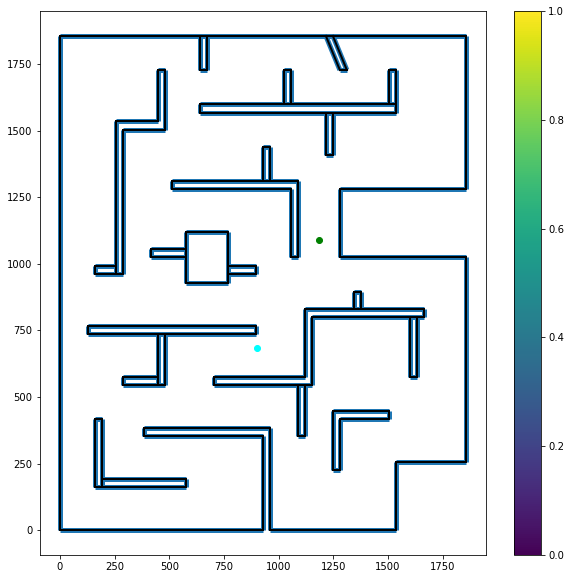

In [18]:
test_start = random_start_goal_pairs[2][0][0]
test_goal = random_start_goal_pairs[2][0][1]

lc = mc.LineCollection(list(zip(full_walls[:, :2], full_walls[:, 2:])),
                       linewidths=5)
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(*test_start[:2], c='green')
plt.scatter(*test_goal[:2], c='cyan')
plt.colorbar()

env.plot_topdown(False)
ax.add_collection(lc)

/home/choang/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


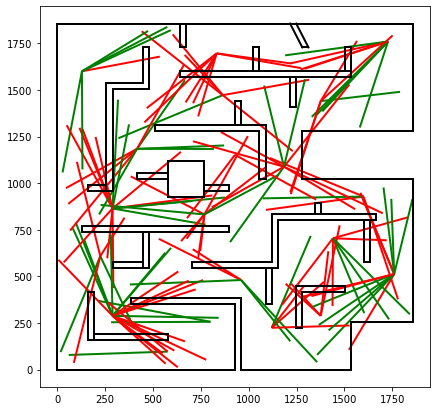

In [19]:
selected_pairs = random_start_goal_pairs[2]
selected_pairs = np.array(selected_pairs)
starts = selected_pairs[:, 0, :2]
goals = selected_pairs[:, 1, :2]
intersections = np.any(get_intersections(walls, np.hstack((starts, goals)).T), axis=1)

colors = ['g', 'r']
line_colors = [colors[i] for i in intersections]
lc = mc.LineCollection(list(zip(starts, goals)),
                       linewidths=2, colors=line_colors)
fig, ax = plt.subplots(figsize=(7, 7))

env.plot_topdown(False)
ax.add_collection(lc)

In [20]:
np.sum(intersections) / len(intersections)

0.6131386861313869

In [21]:
final_random_start_goal_pairs = {}
final_random_start_goal_pairs['easy'] = random_start_goal_pairs[0]
final_random_start_goal_pairs['medium'] = random_start_goal_pairs[1]
final_random_start_goal_pairs['hard'] = random_start_goal_pairs[2]

New
- easy (100 steps): 0% are across the wall
- medium (200 steps): 41% are across the wall
- hard (300 steps): 65% are across the wall

Old
- easy (100 steps): 25% are across the wall
- medium (200 steps): 64% are across the wall
- hard (300 steps): 83% are across the wall

In [22]:
with open('../experiments/configs/{}-train-random-start-goal-pairs.json'.format(seed), 'w') as f:
    json.dump(final_random_start_goal_pairs, f)

### Random vs Fixed Spawn in SGM

In [89]:
with open('../experiments/configs/memory-train-full.json', 'r') as f:
    config = json.load(f)
config['env']['config'] = '../experiments/vizdoom/train_SPTM.cfg'
config['env']

{'config': '../experiments/vizdoom/train_SPTM.cfg',
 'seed': 100,
 'grayscale': False,
 'map_id': 'map05',
 'num_samples': -1,
 'num_img_obs': 4,
 'full_action_set': True}

In [ ]:
def test_spawn(start_position=None):
    config['env']['start_position'] = start_position
    env = VizDoomEnv(**config['env'])
    
    num_eps = 100
    num_frames_per_eps = 200
    
    locations = []
    for i in range(num_eps):
        env.reset()
        current_episode_locations = [env.agent_pos]
        for j in range(num_frames_per_eps):
            env.step(env.action_space.sample())
            current_episode_locations.append(env.agent_pos)
        locations.append(current_episode_locations)
    all_episodes = np.array(locations)
    plt.figure(figsize=(14, 14))
    env.plot_topdown()
    plt.scatter(all_episodes[:, :, 0].flatten(), all_episodes[:, :, 1].flatten())
    plt.title('Fixed Spawn' if start_position else 'Random Spawn')

In [ ]:
test_spawn(start_position=None)

In [ ]:
test_spawn(start_position=[1000, 1000, 0])

In [67]:
with open('../experiments/configs/fixed-spawn.json') as f:
    config = json.load(f)
    config['env']['config'] = '../experiments/vizdoom/small_SPTM.cfg'

In [97]:
seed = make_seed()
print(seed)
set_seed(seed)

1255
using seed 1255


In [98]:
env = VizDoomEnv(**config['env'])

In [99]:
num_trajectories = 10
num_steps = 10
eval_data = defaultdict(list)

In [100]:
angles = 360 / num_trajectories
for i in range(num_trajectories):
    start = [200, -150, i * angles]
    env.set_start_state(start)
    env.start_position = start
    env.reset()
    for j in range(num_steps):
        obs, reward, done, env_info = env.step(2)
        eval_data[j + 1].append([start, list(env_info.position)])

In [101]:
with open('../experiments/configs/{}-small-mapping-start-goal-pairs.json'.format(seed), 'w') as f:
    json.dump(eval_data, f)

In [104]:
eval_data = {k: np.array(eval_data[k]) for k in eval_data}

In [108]:
eval_data[1]

(10, 2, 3)

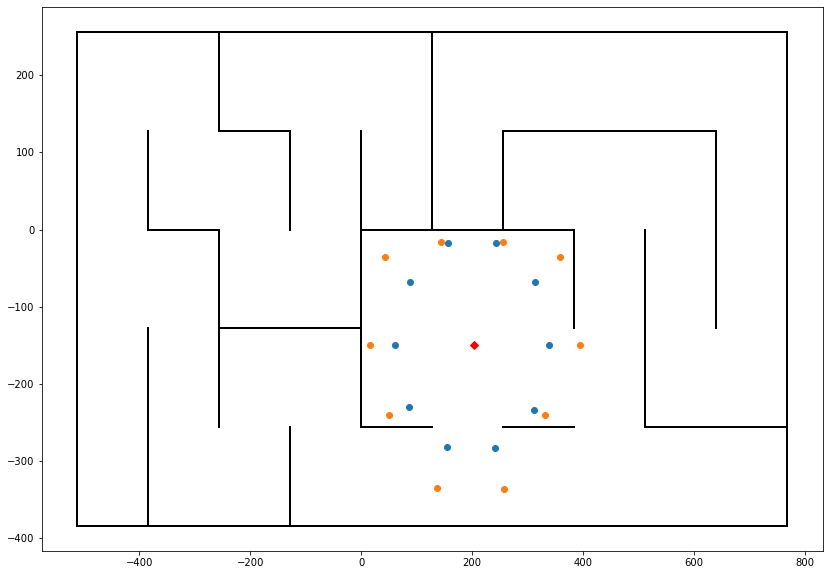

In [111]:
steps_away = 4
plt.figure(figsize=(14, 10))
env.plot_topdown()
plt.scatter(eval_data[steps_away][:, 1, 0], eval_data[steps_away][:, 1, 1])
steps_away = 5
plt.scatter(eval_data[steps_away][:, 1, 0], eval_data[steps_away][:, 1, 1])